RNN LSTM for text classification
=============
<span style="color: lightsteelblue;">Deep Learning</span>

The goal of this notebook is to train recurrent neural network with LSTM cell for the purpose of text classification.

## 1. Data preparation

In [1]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.

# from __future__ import print_function

import collections
import numpy as np
import matplotlib.pyplot as plt
# import random
# import re
# import string
import tensorflow as tf

# from six.moves import range
# from six.moves.urllib.request import urlretrieve

# custom library
from nlp.preparer import Corpus

### Loading corpora

In [2]:
corpora_paths = ['./articles/good.articles', './articles/bad.articles'] 
corpora = []
lengths = []

for path in corpora_paths:
  corpus = Corpus(path)
  corpora.append(corpus)
  length = [len(article) for article in corpus.articles]
  lengths.append(length)

  print(f"Corpus label: {corpus.label}, ",
        f"length: {len(corpus.articles)} articles, ",
        f"av length: {round(corpus.average_length())} words, ",
        f"max length: {max(length)} words.")
  print(f"Corpus raw article: {corpus.raw[0][:200]}")
  print(f"Corpus data (words): {corpus.articles[0][:20]}\n")

Corpus label: good,  length: 6666 articles,  av length: 321 words,  max length: 4977 words.
Corpus raw article: 3 февраля в большинстве европейских стран закрылось зимнее трансферное окно — период, когда клубы могут заявлять новых футболистов, купленных у других команд. Ценники меняются чуть ли не ежемесячно. Н
Corpus data (words): ['num', 'февраля', 'в', 'большинстве', 'европейских', 'стран', 'закрылось', 'зимнее', 'трансферное', 'окно', 'период', ',', 'когда', 'клубы', 'могут', 'заявлять', 'новых', 'футболистов', ',', 'купленных']

Corpus label: bad,  length: 7519 articles,  av length: 84 words,  max length: 594 words.
Corpus raw article: Неизвестный угрожает взорвать аэропорт Кишинева, если ему не дадут миллион. Неизвестный сообщил о бомбе в аэропорту Международного аэропорта Кишинева и требует миллион рублей, сообщили в пограничной п
Corpus data (words): ['неизвестный', 'угрожает', 'взорвать', 'аэропорт', 'кишинева', ',', 'если', 'ему', 'не', 'дадут', 'миллион', '.', 'неизвестный',

### Binning articles by their lengths

Number of bins: 52
Now our bins contain these numbers of articles: [{6: 4}, {7: 31}, {8: 85}, {9: 225}, {10: 355}, {11: 525}, {12: 603}, {13: 724}, {14: 711}, {15: 619}, {16: 562}, {17: 536}, {18: 460}, {19: 376}, {20: 300}, {21: 260}, {22: 206}, {23: 166}, {24: 131}, {25: 121}, {26: 98}, {27: 80}, {28: 79}, {29: 42}, {30: 41}, {31: 25}, {32: 31}, {33: 15}, {34: 19}, {35: 14}, {36: 6}, {37: 9}, {38: 13}, {39: 8}, {40: 7}, {41: 2}, {42: 3}, {43: 1}, {44: 4}, {45: 2}, {46: 4}, {48: 2}, {49: 3}, {50: 2}, {51: 1}, {52: 1}, {53: 1}, {57: 1}, {58: 2}, {60: 1}, {82: 1}, {118: 1}]
Now each article is padded by 2.5 words in average: ['этим', 'правоохранительные', 'органы', 'ищут', 'отправившего', 'сообщение', '.', 'PAD', 'PAD', 'PAD']


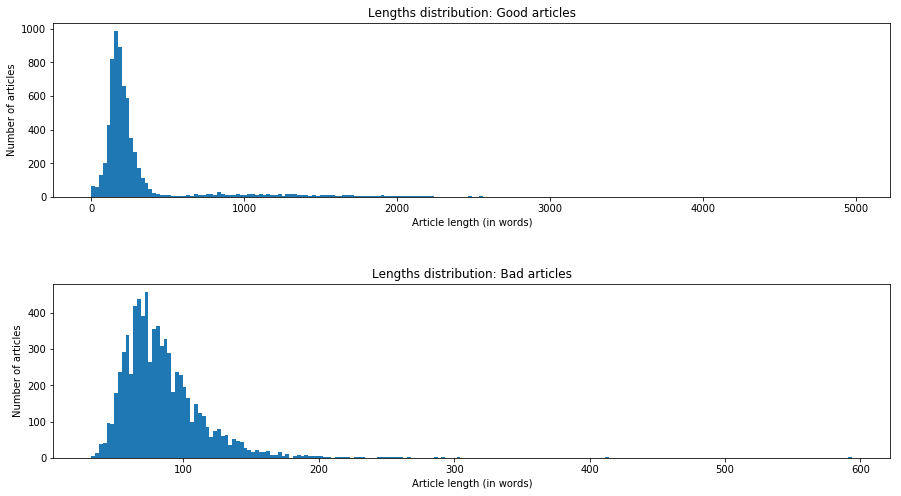

In [3]:
bin_size = 5

bins = {}
for article in corpora[1].articles:
  length = len(article)
  key = length // bin_size 
  if key in bins.keys():
    bins[key].append(article)
  else:
    bins[key] = [article]

print(f"Number of bins: {len(bins)}")
bins_representation = [{ key : len(bins[key]) } for key in sorted(bins.keys())]
print(f"Now our bins contain these numbers of articles: {bins_representation}")

# Padding articles to match bins' lengths
for key in bins:
  must_be = (key + 1) * bin_size - 1
  for article in bins[key]:
    length = len(article)
    if length < must_be:
      how_less = must_be - length
      for _ in range(how_less): article.append('PAD')

print(f"Now each article is padded by {bin_size / 2} words in average: {corpus.articles[0][-10:]}")

# visualization
plt.figure().set_size_inches(15, 8)

plt.subplot(211)
plt.xlabel('Article length (in words)')
plt.ylabel('Number of articles')
plt.title('Lengths distribution: Good articles')
plt.hist(lengths[0], 200)

plt.subplots_adjust(hspace=.5)

plt.subplot(212)
plt.xlabel('Article length (in words)')
plt.ylabel('Number of articles')
plt.title('Lengths distribution: Bad articles')
plt.hist(lengths[1], 200)

plt.show()

In [4]:
vocabulary_size = 25000

def build_dataset(words):
  count = [['UNK', -1]]
  count.extend(collections.Counter(words).most_common(vocabulary_size - 1))
  dictionary = dict()
  for word, _ in count:
    dictionary[word] = len(dictionary)
  data = list()
  unk_count = 0
  for word in words:
    if word in dictionary:
      index = dictionary[word]
    else:
      index = 0  # dictionary['UNK']
      unk_count = unk_count + 1
    data.append(index)
  count[0][1] = unk_count
  reverse_dictionary = dict(zip(dictionary.values(), dictionary.keys())) 
  return data, count, dictionary, reverse_dictionary

# flatten all words into a single bag
all_words = [word for corpus in corpora for words in corpus.articles for word in words]

data, count, dictionary, reverse_dictionary = build_dataset(all_words)

print(f"Top popular words counts: {count[:15]}\n")
print(f"Example word: {dictionary['слон']} => {reverse_dictionary[dictionary['слон']]}")
print(f"<PAD> word: {dictionary['PAD']} => {reverse_dictionary[dictionary['PAD']]}")

Top popular words counts: [['UNK', 311795], (',', 191060), ('.', 167323), ('в', 121865), ('num', 70531), ('и', 59437), ('на', 47376), ('с', 26509), ('что', 22411), ('по', 21883), ('не', 20173), ('из', 16359), ('PAD', 15063), (')', 12317), ('(', 12286)]

Example word: 23733 => слон
<PAD> word: 12 => PAD


Function to generate a training batch for the LSTM model:

In [ ]:
batch_size=32

class BatchGenerator(object):
  def __init__(self, text, batch_size, num_unrollings):
    self._text = text
    self._text_size = len(text)
    self._batch_size = batch_size
    self._num_unrollings = num_unrollings
    segment = self._text_size // batch_size
    self._cursor = [ offset * segment for offset in range(batch_size)]

    self._last_batch = self._next_batch()


  def _next_batch(self):
    """Generate a single batch from the current cursor position in the data."""
    batch = np.zeros(shape=(self._batch_size, vocabulary_size), dtype=np.float)
    for b in range(self._batch_size):
      batch[b, self._text[self._cursor[b]]] = 1.0
      self._cursor[b] = (self._cursor[b] + 1) % self._text_size
    return batch

  def next(self):
    """Generate the next array of batches from the data. The array consists of
    the last batch of the previous array, followed by num_unrollings new ones.
    """
    batches = [self._last_batch]
    for step in range(self._num_unrollings):
      batches.append(self._next_batch())
    self._last_batch = batches[-1]
    return batches

def words(probabilities):
  """Turn a 1-hot encoding or a probability distribution over the possible
  words back into its (most likely) word representation."""
  return [reverse_dictionary[c] for c in np.argmax(probabilities, 1)]

def batches2string(batches):
  for b in batches:
    s = [word for word in words(b)]
  return s

train_batches = BatchGenerator(train_data, batch_size, num_unrollings)
valid_batches = BatchGenerator(valid_data, 1, 1)

print(batches2string(train_batches.next()))
print(batches2string(train_batches.next()))
print(batches2string(valid_batches.next()))
print(batches2string(valid_batches.next()))

In [ ]:
def logprob(predictions, labels):
  """Log-probability of the true labels in a predicted batch."""
  predictions[predictions < 1e-10] = 1e-10
  return np.sum(np.multiply(labels, -np.log(predictions))) / labels.shape[0]

def sample_distribution(distribution):
  """Sample one element from a distribution assumed to be an array of normalized
  probabilities.
  """
  r = random.uniform(0, 1)
  s = 0
  for i in range(len(distribution)):
    s += distribution[i]
    if s >= r:
      return i
  return len(distribution) - 1

def sample(prediction):
  """Turn a (column) prediction into 1-hot encoded samples."""
  p = np.zeros(shape=[1, vocabulary_size], dtype=np.float)
  p[0, sample_distribution(prediction[0])] = 1.0
  return p

def random_distribution():
  """Generate a random column of probabilities."""
  b = np.random.uniform(0.0, 1.0, size=[1, vocabulary_size])
  return b/np.sum(b, 1)[:,None]

LSTM Model:

In [21]:
num_nodes = 64
num_classes = 2 # Number of classes among which to predict
embedding_size = 128 # Dimension of a word vector
num_unrollings = 20 # Number of recurrent steps

graph = tf.Graph()
with graph.as_default():
  
  # Parameters:
  # Input gate: input, previous output, and bias.
  ix = tf.Variable(tf.truncated_normal([embedding_size, num_nodes], -0.1, 0.1))
  im = tf.Variable(tf.truncated_normal([num_nodes, num_nodes], -0.1, 0.1))
  ib = tf.Variable(tf.zeros([1, num_nodes]))
  # Forget gate: input, previous output, and bias.
  fx = tf.Variable(tf.truncated_normal([embedding_size, num_nodes], -0.1, 0.1))
  fm = tf.Variable(tf.truncated_normal([num_nodes, num_nodes], -0.1, 0.1))
  fb = tf.Variable(tf.zeros([1, num_nodes]))
  # Output gate: input, previous output, and bias.
  ox = tf.Variable(tf.truncated_normal([embedding_size, num_nodes], -0.1, 0.1))
  om = tf.Variable(tf.truncated_normal([num_nodes, num_nodes], -0.1, 0.1))
  ob = tf.Variable(tf.zeros([1, num_nodes]))
  # Memory cell: input, state and bias.                             
  cx = tf.Variable(tf.truncated_normal([embedding_size, num_nodes], -0.1, 0.1))
  cm = tf.Variable(tf.truncated_normal([num_nodes, num_nodes], -0.1, 0.1))
  cb = tf.Variable(tf.zeros([1, num_nodes]))
  # Variables saving state across unrollings.
  saved_output = tf.Variable(tf.zeros([1, num_nodes]), trainable=False)
  saved_state = tf.Variable(tf.zeros([1, num_nodes]), trainable=False)
  # Classifier weights and biases.
  w = tf.Variable(tf.truncated_normal([num_nodes, num_classes], -0.1, 0.1))
  b = tf.Variable(tf.zeros([num_classes]))
  # Embeddings
  embeddings = tf.Variable(tf.random_uniform([vocabulary_size, embedding_size], -1.0, 1.0))


  # Definition of the cell computation.
  def lstm_cell(i, o, state):
    """Create a LSTM cell. See e.g.: http://arxiv.org/pdf/1402.1128v1.pdf
    Note that in this formulation, we omit the various connections between the
    previous state and the gates."""
    input_gate = tf.sigmoid(tf.matmul(i, ix) + tf.matmul(o, im) + ib)
    forget_gate = tf.sigmoid(tf.matmul(i, fx) + tf.matmul(o, fm) + fb)
    output_gate = tf.sigmoid(tf.matmul(i, ox) + tf.matmul(o, om) + ob)
    update = tf.matmul(i, cx) + tf.matmul(o, cm) + cb
    state = forget_gate * state + input_gate * tf.tanh(update)

    return output_gate * tf.tanh(state), state

  # Input data.
  train_inputs = tf.placeholder(tf.int32, shape=[num_unrollings])
  train_labels = tf.placeholder(tf.int32, shape=[num_unrollings, num_classes])

  # Unrolled LSTM loop.
  lstm_outputs = list()
  output = saved_output
  state = saved_state
  lstm_inputs = tf.unstack(tf.nn.embedding_lookup(embeddings, train_inputs)) # ~ (num_unrollings, embedding_size)
  
  for lstm_input in lstm_inputs:
    reshaped_lstm_input = tf.reshape(lstm_input, (1, embedding_size))
    output, state = lstm_cell(reshaped_lstm_input, output, state)
    lstm_outputs.append(output)

  # State saving across unrollings.
  with tf.control_dependencies([saved_output.assign(output),
                                saved_state.assign(state)]):
    # Classifier.
    logits = tf.nn.xw_plus_b(tf.concat(lstm_outputs, 0), w, b) # ~ (num_unrollings, num_classes)
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(
      labels=train_labels,
      logits=logits
    ))

  # Optimizer.
  global_step = tf.Variable(0)
  learning_rate = tf.train.exponential_decay(
    10.0, global_step, 5000, 0.1, staircase=True)
  optimizer = tf.train.GradientDescentOptimizer(learning_rate)
  gradients, v = zip(*optimizer.compute_gradients(loss))
  gradients, _ = tf.clip_by_global_norm(gradients, 1.25)
  optimizer = optimizer.apply_gradients(
    zip(gradients, v), global_step=global_step)

  # Predictions.
  train_prediction = tf.nn.softmax(logits)

#   # Sampling and validation eval: batch 1, no unrolling.
#   sample_input = tf.placeholder(tf.float32, shape=[1, vocabulary_size])
#   saved_sample_output = tf.Variable(tf.zeros([1, num_nodes]))
#   saved_sample_state = tf.Variable(tf.zeros([1, num_nodes]))
#   reset_sample_state = tf.group(
#     saved_sample_output.assign(tf.zeros([1, num_nodes])),
#     saved_sample_state.assign(tf.zeros([1, num_nodes])))
#   sample_output, sample_state = lstm_cell(
#     sample_input, saved_sample_output, saved_sample_state)
#   with tf.control_dependencies([saved_sample_output.assign(sample_output),
#                                 saved_sample_state.assign(sample_state)]):
#     sample_prediction = tf.nn.softmax(tf.nn.xw_plus_b(sample_output, w, b))

In [ ]:
num_steps = 7001
summary_frequency = 100

with tf.Session(graph=graph) as session:
  tf.global_variables_initializer().run()
  print('Initialized')
  mean_loss = 0
  for step in range(num_steps):
    batches = train_batches.next()
    feed_dict = { train_inputs:  }

      feed_dict[train_data[i]] = batches[i]
    _, l, predictions, lr = session.run(
      [optimizer, loss, train_prediction, learning_rate], feed_dict=feed_dict)
    mean_loss += l

    if step % summary_frequency == 0:
      if step > 0:
        mean_loss = mean_loss / summary_frequency
      # The mean loss is an estimate of the loss over the last few batches.
      print(
        'Average loss at step %d: %f learning rate: %f' % (step, mean_loss, lr))
      mean_loss = 0

#       labels = np.concatenate(list(batches)[1:])
#       print('Minibatch perplexity: %.2f' % float(
#         np.exp(logprob(predictions, labels))))
#       if step % (summary_frequency * 10) == 0:
#         # Generate some samples.
#         print('=' * 80)
#         for _ in range(5):
#           feed = sample(random_distribution())
#           sentence = characters(feed)[0]
#           reset_sample_state.run()
#           for _ in range(79):
#             prediction = sample_prediction.eval({sample_input: feed})
#             feed = sample(prediction)
#             sentence += characters(feed)[0]
#           print(sentence)
#         print('=' * 80)
#       # Measure validation set perplexity.
#       reset_sample_state.run()
#       valid_logprob = 0
#       for _ in range(valid_size):
#         b = valid_batches.next()
#         predictions = sample_prediction.eval({sample_input: b[0]})
#         valid_logprob = valid_logprob + logprob(predictions, b[1])
#       print('Validation set perplexity: %.2f' % float(np.exp(
#         valid_logprob / valid_size)))